# Environment Setup

## pips

In [ ]:
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 12.1 MB/s eta 0:00:00


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 41.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


## libs

In [ ]:
import librosa
import numpy as np
from PIL import Image
from IPython.display import Audio
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

# Class and Function Declerations

In [ ]:
from dataclasses import dataclass

import os
os.environ["HF_TOKEN"] = "<your_hf_access_token>"

@dataclass
class TrainingConfig:
    image_size: int = 256  # the generated image resolution
    sample_rate: int = 22050  # the sample rate of the audio
    train_batch_size: int = 200
    eval_batch_size: int = 1  # how many images to sample during evaluation
    num_epochs: int = 100
    gradient_accumulation_steps: int = 1
    learning_rate: float = 1e-4
    lr_warmup_steps: int = 500
    save_image_epochs: int = 10
    save_model_epochs: int = 10
    mixed_precision: str = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir: str = "out"  # the model name locally and on the HF Hub
    resume_epoch: int = 0  # the epoch to resume training from
    resume_training: bool = True
    push_to_hub: bool = True  # whether to upload the saved model to the HF Hub
    hub_model_id: str = "<your_hf_model_id>"  # the name of the repository to create on the HF Hub
    hub_private_repo: bool = True
    overwrite_output_dir: bool = True  # overwrite the old model when re-running the notebook
    seed: int = 0


config = TrainingConfig()

## dataset

In [ ]:
from typing import Optional
class Mel:
  def __init__(
        self,
        file_path: str = None,
        spectrogram: Optional[np.ndarray] = None,
        image: Image.Image= None,
        x_res: int = 256,
        y_res: int = 256,
        sample_rate: int = config.sample_rate,
        n_fft: int = 2048,
        hop_length: int = 512,
        top_db: int = 80,
        n_iter: int = 32):
    self.hop_length = hop_length
    self.sr = sample_rate
    self.n_fft = n_fft
    self.top_db = top_db
    self.n_iter = n_iter
    self.x_res = x_res
    self.y_res = y_res
    self.n_mels = self.y_res
    self.slice_size = self.x_res * self.hop_length - 1
    self.file_path = file_path
    self.spectrogram = spectrogram
    self.image = image

    if file_path is not None and not isinstance(file_path, str):
        raise ValueError("file_path must be a string")
    if spectrogram is not None and not isinstance(spectrogram, np.ndarray):
        raise ValueError("spectrogram must be an ndarray")
    if image is not None and not isinstance(image, Image.Image):
        raise ValueError("image must be a PIL Image")

    if file_path is not None:
      self.load_file()
    elif image is not None:
      self.load_spectrogram()
    elif spectrogram is not None:
      self.load_image()
    else:
      print("both file path and image is none!")


  def load_file(self):
    try:
      # load
      if ".wav" in self.file_path:
        audio, _ = librosa.load(self.file_path, mono=True, sr=self.sr)
      # pad
      if len(audio) < self.x_res * self.hop_length:
              audio = np.concatenate([audio, np.zeros((self.x_res * self.hop_length - len(audio),))])
      # mel spectrogram
      S = librosa.feature.melspectrogram(
              y=audio, sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels
          )
      log_S = librosa.power_to_db(S, ref=np.max, top_db=self.top_db)
      log_S = log_S[:256, :256]
      self.spectrogram = (((log_S + self.top_db) * 255 / self.top_db).clip(0, 255) + 0.5).astype(np.uint8)
      # normalize
      # self.spectrogram = self.spectrogram / 255.0
      self.image = Image.fromarray(self.spectrogram)
    except Exception as e:
      print(f"Error loading {self.file_path}: {e}")


  def load_spectrogram(self):
    self.spectrogram = np.array(self.image)

  def load_image(self):
    self.spectrogram = self.spectrogram.astype("uint8")
    self.image = Image.fromarray(self.spectrogram)

  def get_spectrogram(self):
    return self.spectrogram

  def get_image(self):
    return self.image

  def get_audio(self):
    # denormalize
    # self.spectrogram = self.spectrogram * 255.0
    log_S = self.spectrogram.astype("float") * self.top_db / 255 - self.top_db
    S = librosa.db_to_power(log_S)
    audio = librosa.feature.inverse.mel_to_audio(
        S, sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length, n_iter=self.n_iter
    )
    display(Audio(audio, rate=self.sr))



  def plot_spectrogram(self):
    plt.figure(figsize=(10, 4))
    plt.imshow(self.spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time (frames)')
    plt.ylabel('Frequency (Mel bins)')
    plt.tight_layout()
    plt.show()


In [ ]:
from torch.utils.data import DataLoader, Dataset

class AudioDataset(Dataset):
  def __init__(self, folder_path):
    self.folder_path = folder_path
    self.instances = []
    self.load()

  def load(self):
    if self.folder_path is None:
      print("folder path should not be none")
      return
    files = os.listdir(self.folder_path)
    for file in tqdm(files, desc='Loading wav files'):
      if ".wav" in file:
        mel = Mel(file_path=os.path.join(self.folder_path, file))
        if mel.get_spectrogram() is not None:
          self.instances.append(mel)
    print(len(self.instances), "files loaded.")

  def __getitem__(self, index):
    item = self.instances[index].get_spectrogram()
    if item is None:
        print(f"Warning: Missing data at index {index}")
        return None
    if not isinstance(item, torch.Tensor):
      item = torch.tensor(item).unsqueeze(0).float()
    return item

  def __len__(self):
    return len(self.instances)

  def getMel(self, index):
    return self.instances[index]

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from datasets import load_dataset
from PIL import Image

class HFDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = Compose([
            ToTensor(),
            # Lambda(lambda x: x.clamp(0, 1))
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']  # Convert array to PIL image (if necessary)

        if image.mode != 'L':
            image = image.convert('L')
        image = self.transform(image)

        return image

# Load dataset from Hugging Face
dataset = load_dataset("teticio/audio-diffusion-256", split='train')

# Create an instance of the HFDataset
hf_dataset = HFDataset(dataset)

# Create a DataLoader
data_loader = DataLoader(hf_dataset, batch_size=config.train_batch_size, shuffle=True)  # Adjust batch size as per your config

# Example: Iterate over the DataLoader
for batch in data_loader:
    print(batch.shape)  # Expected output: torch.Size([batch_size, 1, 256, 256])
    break


Generating train split:   0%|          | 0/21571 [00:00<?, ? examples/s]

torch.Size([200, 1, 256, 256])


In [ ]:
item = hf_dataset.__getitem__(5450)
item

tensor([[[0.4549, 0.4039, 0.4118,  ..., 0.4039, 0.4118, 0.4549],
         [0.4706, 0.4431, 0.4000,  ..., 0.4431, 0.4392, 0.5098],
         [0.4980, 0.4588, 0.3059,  ..., 0.4392, 0.4118, 0.5255],
         ...,
         [0.0784, 0.0863, 0.0863,  ..., 0.0000, 0.0000, 0.0549],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0353]]])

In [ ]:
def tensor_to_mel(tensor):
    s = np.array(tensor.squeeze())*255
    return Mel(spectrogram=s)

mel = tensor_to_mel(item)
mel.get_audio()

In [ ]:
dataloader = DataLoader(hf_dataset, batch_size=config.train_batch_size, shuffle=True)
dataloader

# Model

In [ ]:
from torch import nn
from torch.nn import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## VAE

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_channels=1, hidden_dims=[512, 256, 128, 64, 32], latent_dim=16):
        super(Encoder, self).__init__()
        self.hidden_dims = hidden_dims

        # Build Encoder with Residual Blocks
        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(input_channels, h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                    ResidualBlock(h_dim)  # Adding a residual block
                )
            )
            input_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*8*8, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*8*8, latent_dim)

    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=16, output_channels=1, hidden_dims=[512, 256, 128, 64, 32]):
        super(Decoder, self).__init__()
        self.hidden_dims = hidden_dims
        # Reversing the order for the decoder
        hidden_dims = hidden_dims[::-1]
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[0]*8*8)



        # Build Decoder with Residual Blocks
        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i+1], kernel_size=3, stride=2, padding=1, output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i+1]),
                    nn.LeakyReLU(),
                    ResidualBlock(hidden_dims[i+1])  # Adding a residual block
                )
            )

        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1], hidden_dims[-1], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], output_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        z = self.decoder_input(z)
        z = z.view(-1, 512, 8, 8)
        for layer in self.decoder:
            z = layer(z)
        result = self.final_layer(z)
        return result


In [ ]:
class VAE(nn.Module):
    def __init__(self,
                 input_channels=1,
                 latent_dim=16,
                 hidden_dims=None):
        super(VAE, self).__init__()

        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        self.encoder = Encoder(input_channels=input_channels,
                               hidden_dims=hidden_dims,
                               latent_dim=latent_dim)

        self.decoder = Decoder(latent_dim=latent_dim,
                               output_channels=input_channels,
                               hidden_dims=hidden_dims)

    def encode(self, input):
        mu, log_var = self.encoder(input)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, input):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var



In [ ]:
import torch.nn.functional as F
# Loss function for VAE
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + 0.001 * KLD

In [ ]:
import torch
from torch.optim import Adam

learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Initialize the VAE model
latent_dim = 32
# vae = VAE(input_channels=1, latent_dim=latent_dim).to(device)
vae = torch.load('/content/drive/MyDrive/bitirme_data/vae_model.pth').to(device)
optimizer = Adam(vae.parameters(), lr=learning_rate)

cuda


## Training

original:


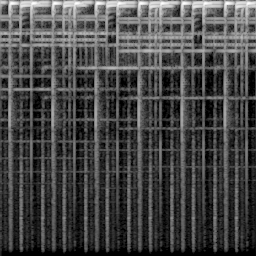

recon:


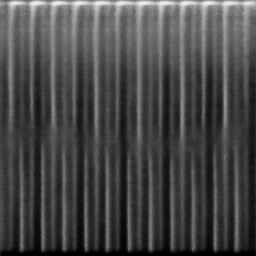

loss:  tensor(34897.0469, device='cuda:0')


In [ ]:
def try_model(model, index):
    item = hf_dataset.__getitem__(index)
    sample = tensor_to_mel(item)
    print("original:")
    sample.get_audio()
    display(sample.get_image())
    item = item.unsqueeze(0)

    model.eval()
    item = item.to('cuda')

    with torch.no_grad():
        recon_batch, mu, log_var = model(item)
        recon = recon_batch.squeeze(1)
        recon_mel = tensor_to_mel(recon.cpu())
        print("recon:")
        recon_audio = recon_mel.get_audio()
        recon_image = recon_mel.get_image()
        display(recon_image)
        mu, log_var = model.encode(item)
        z = model.reparameterize(mu, torch.zeros_like(mu))
        loss = loss_function(recon_batch, item, mu, log_var)
        print("loss: ",loss)


try_model(vae,256)

Train Epoch: 1 [18297/21571 (99%)] Loss: 39444.596491: 100%|██████████| 108/108 [02:32<00:00,  1.41s/it]


====> Epoch: 1 Average loss: 40177.7532


Train Epoch: 2 [18297/21571 (99%)] Loss: 40397.912281: 100%|██████████| 108/108 [02:33<00:00,  1.42s/it]


====> Epoch: 2 Average loss: 40172.1454


Train Epoch: 3 [18297/21571 (99%)] Loss: 40460.640351: 100%|██████████| 108/108 [02:33<00:00,  1.42s/it]


====> Epoch: 3 Average loss: 40169.1119


Train Epoch: 4 [18297/21571 (99%)] Loss: 40573.482456: 100%|██████████| 108/108 [02:33<00:00,  1.42s/it]


====> Epoch: 4 Average loss: 40164.8802


Train Epoch: 5 [18297/21571 (99%)] Loss: 39790.096491: 100%|██████████| 108/108 [02:32<00:00,  1.42s/it]


====> Epoch: 5 Average loss: 40159.9729


Train Epoch: 6 [18297/21571 (99%)] Loss: 39848.836257: 100%|██████████| 108/108 [02:32<00:00,  1.42s/it]


====> Epoch: 6 Average loss: 40160.3736


Train Epoch: 7 [18297/21571 (99%)] Loss: 40298.207602: 100%|██████████| 108/108 [02:33<00:00,  1.42s/it]


====> Epoch: 7 Average loss: 40156.4334


Train Epoch: 8 [18297/21571 (99%)] Loss: 39495.643275: 100%|██████████| 108/108 [02:33<00:00,  1.42s/it]


====> Epoch: 8 Average loss: 40152.7517


Train Epoch: 9 [18297/21571 (99%)] Loss: 39771.248538: 100%|██████████| 108/108 [02:32<00:00,  1.42s/it]


====> Epoch: 9 Average loss: 40150.4152


Train Epoch: 10 [18297/21571 (99%)] Loss: 40019.154971: 100%|██████████| 108/108 [02:32<00:00,  1.42s/it]


====> Epoch: 10 Average loss: 40146.8465
original:


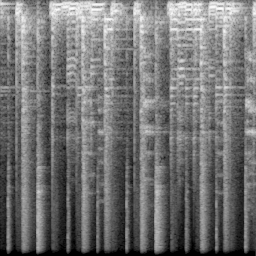

recon:


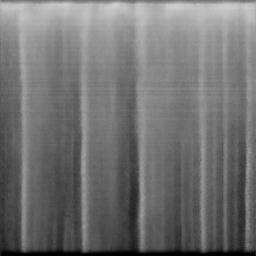

loss:  tensor(42024.5312, device='cuda:0')


Train Epoch: 11 [18297/21571 (99%)] Loss: 40306.304094: 100%|██████████| 108/108 [02:33<00:00,  1.42s/it]


====> Epoch: 11 Average loss: 40142.6138


Train Epoch: 12 [18297/21571 (99%)] Loss: 40519.137427: 100%|██████████| 108/108 [02:33<00:00,  1.42s/it]


====> Epoch: 12 Average loss: 40140.7175


Train Epoch: 13 [18297/21571 (99%)] Loss: 40272.967836: 100%|██████████| 108/108 [02:33<00:00,  1.42s/it]


====> Epoch: 13 Average loss: 40135.3096


Train Epoch: 14 [18297/21571 (99%)] Loss: 39845.122807: 100%|██████████| 108/108 [02:33<00:00,  1.42s/it]


====> Epoch: 14 Average loss: 40132.3215


Train Epoch: 15 [18297/21571 (99%)] Loss: 40005.500000: 100%|██████████| 108/108 [02:33<00:00,  1.42s/it]


====> Epoch: 15 Average loss: 40129.3954


Train Epoch: 16 [18297/21571 (99%)] Loss: 40338.979532: 100%|██████████| 108/108 [02:33<00:00,  1.42s/it]


====> Epoch: 16 Average loss: 40127.6164


Train Epoch: 17 [18297/21571 (99%)] Loss: 40244.748538: 100%|██████████| 108/108 [02:33<00:00,  1.42s/it]


====> Epoch: 17 Average loss: 40124.0330


Train Epoch: 18 [0/21571 (0%)] Loss: 40371.515000:   1%|          | 1/108 [00:02<04:59,  2.80s/it]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
import random

def train(epoch, dataloader):
    vae.train()
    train_loss = 0
    perceptual_loss_counter = 0
    ex_loss_counter = 0
    total_batches = len(dataloader)

    progress_bar = tqdm(enumerate(dataloader), total=total_batches, desc=f"Epoch {epoch}")

    for batch_idx, data in progress_bar:
        if data is None:
            progress_bar.set_description("Skipped batch due to None data")
            continue

        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data)

        if torch.any(torch.isnan(recon_batch)) or torch.any(torch.isinf(recon_batch)):
            print("NaN or Inf in recon_batch")
            print(recon_batch)
            break

        if torch.any(torch.isnan(mu)) or torch.any(torch.isinf(mu)) or torch.any(torch.isnan(log_var)) or torch.any(torch.isinf(log_var)):
            print("NaN or Inf in mu or log_var")
            print(mu, log_var)
            break

        loss = loss_function(recon_batch, data, mu, log_var)

        if torch.isnan(loss) or torch.isinf(loss):
            print("NaN or Inf in loss")
            print(loss)
            break

        loss.backward()

        for param in vae.parameters():
            if param.grad is not None and (torch.any(torch.isnan(param.grad)) or torch.any(torch.isinf(param.grad))):
                print("NaN or Inf in gradients")
                print(param.grad)
                break

        optimizer.step()
        train_loss += loss.item()

        # Update the progress bar description
        progress_bar.set_description(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)}"
                                     f" ({100. * batch_idx / total_batches:.0f}%)] Loss: {loss.item() / len(data):.6f}")




    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(dataloader.dataset):.4f}')
    #print(f'====> Epoch: {epoch} Average ex_loss: {ex_loss_counter / len(dataloader.dataset):.4f}')
    #print(f'====> Epoch: {epoch} Average percep_loss: {perceptual_loss_counter / len(dataloader.dataset):.4f}')
    if epoch % 10 == 0:
      random_index = random.randint(1, 20000)
      try_model(vae, random_index)

    return train_loss / len(dataloader.dataset)



previous_loss = 0
counter = 0
num_epochs = 50

for epoch in range(1, num_epochs + 1):
    epoch_loss = train(epoch, dataloader)
    if epoch_loss > previous_loss and previous_loss != 0:
        counter += 1
    if counter == 3:
        break
    previous_loss = epoch_loss


original:


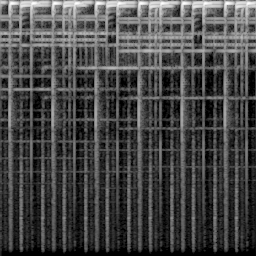

recon:


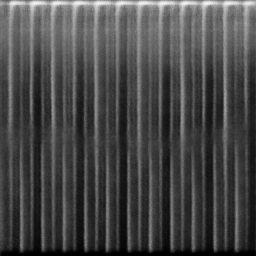

loss:  tensor(34667.7188, device='cuda:0')


In [ ]:
try_model(vae,256)

In [ ]:
# save_path = '<drive_save_path>'
torch.save(vae.state_dict(), save_path + '/vae_model_state_dict_pth')
torch.save(vae, save_path + '/vae_model.pth')

In [ ]:
from google.colab import runtime
print("done")
runtime.unassign()

## Playground

In [ ]:
import torch
from torch.utils.data import DataLoader
from scipy.spatial import distance
import numpy as np

def get_closest_pairs(vae, dataset, num_samples=10000):
    vae.eval()
    dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

    latents = []
    with torch.no_grad():
        for data in dataloader:
            inputs = data.to(device)
            mu, log_var = vae.encode(inputs)
            combined_latent = torch.cat((mu, log_var),dim=1)
            latents.append(combined_latent)

            if sum([len(batch) for batch in latents]) >= num_samples:
                break

    latents = torch.cat(latents, dim=0)[:num_samples].cpu().numpy()

    # Calculate pairwise Euclidean distances
    dist_matrix = distance.cdist(latents, latents, 'euclidean')

    # Ensure diagonal is set to infinity to ignore self-comparisons
    np.fill_diagonal(dist_matrix, np.inf)

    # Find the indices of the five closest pairs
    flat_index = np.argpartition(dist_matrix.ravel(), 100)[:100]
    row_indices, col_indices = np.unravel_index(flat_index, dist_matrix.shape)

    closest_pairs = list(zip(row_indices, col_indices))
    distances = [dist_matrix[row, col] for row, col in closest_pairs]

    return closest_pairs, distances

# Example usage assuming you have a VAE model 'vae' and a dataset 'dataset'
closest_pairs, distances = get_closest_pairs(vae, hf_dataset)
for pair, dist in zip(closest_pairs, distances):
    print(f"Pair: {pair}, Distance: {dist}")


Pair: (9797, 9798), Distance: 0.39101313170960567
Pair: (9798, 9797), Distance: 0.39101313170960567
Pair: (9800, 9797), Distance: 0.3246678890958409
Pair: (9799, 9803), Distance: 0.35149208602926924
Pair: (9799, 9798), Distance: 0.336255359090546
Pair: (9798, 9803), Distance: 0.3340110653903242
Pair: (9798, 9800), Distance: 0.4072856739506294
Pair: (9798, 9799), Distance: 0.336255359090546
Pair: (9803, 9797), Distance: 0.3132215413092069
Pair: (9800, 9803), Distance: 0.3800503742831726
Pair: (9797, 9803), Distance: 0.3132215413092069
Pair: (9803, 9798), Distance: 0.3340110653903242
Pair: (9803, 9799), Distance: 0.35149208602926924
Pair: (9797, 9800), Distance: 0.3246678890958409
Pair: (9803, 9800), Distance: 0.3800503742831726
Pair: (9800, 9798), Distance: 0.4072856739506294
Pair: (9798, 9801), Distance: 0.9423929021053815
Pair: (9140, 9168), Distance: 0.9295723406928182
Pair: (9803, 9801), Distance: 0.9715483836418944
Pair: (9802, 9799), Distance: 0.415084412099656
Pair: (9800, 9799),

Closest pairs seems to be in located in the same song which is a great indicator that vae is succesful in some way.

original:


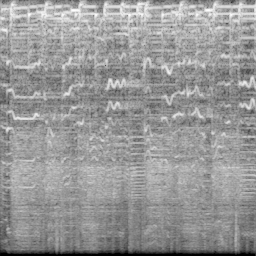

recon:


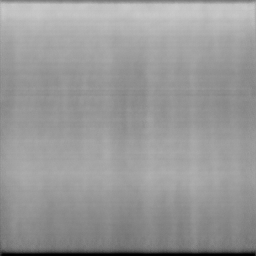

z:  torch.Size([1, 32])
tensor([[-0.8909,  0.8180, -0.5069,  0.4346, -0.0998,  0.1665, -1.3338, -0.0788,
          0.5892,  0.0938, -0.4697, -0.1336,  0.3391,  0.7910,  1.1286, -0.6140,
          1.6391, -0.7882,  1.5608, -1.4579,  0.1772, -0.4930, -0.1630, -0.6070,
          0.8578, -0.0324, -0.1184, -0.5338, -0.0290,  1.3834,  0.7459, -0.6061]],
       device='cuda:0')
tensor([[-4.0156, -3.3850, -3.4741, -3.7752, -2.9073, -3.0632, -4.4354, -3.3693,
         -2.9226, -2.9890, -2.7450, -3.1882, -3.7710, -3.1137, -2.9347, -3.5579,
         -3.6322, -3.2292, -2.9488, -5.2464, -3.4220, -3.0352, -4.2161, -3.0788,
         -3.5163, -4.7324, -3.0245, -4.6336, -2.8556, -5.7050, -4.2701, -3.5550]],
       device='cuda:0')
original:


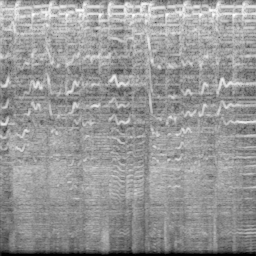

recon:


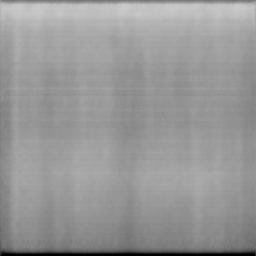

z:  torch.Size([1, 32])
tensor([[-1.1244,  1.1403, -0.4395,  0.3818, -0.5034,  0.1020, -1.2156,  0.1614,
          0.5708,  0.0346, -0.4897, -0.2143,  0.2283,  0.6633,  1.0981, -0.5744,
          1.5913, -0.6912,  1.3741, -1.6063,  0.0412, -0.1064, -0.0114, -0.6286,
          1.1927, -0.2944, -0.0193, -0.2355, -0.0784,  1.3088,  0.7728, -0.7797]],
       device='cuda:0')
tensor([[-3.9893, -3.3475, -3.4731, -3.7103, -2.9692, -3.0093, -4.4175, -3.2772,
         -2.8662, -2.9698, -2.6412, -3.1547, -3.7529, -3.1779, -2.8915, -3.5915,
         -3.6327, -3.2300, -2.9164, -5.2616, -3.3239, -2.9960, -4.1770, -3.0236,
         -3.4617, -4.7865, -2.9802, -4.5613, -2.8968, -5.7556, -4.2434, -3.5279]],
       device='cuda:0')


In [ ]:
try_model(vae,198)
try_model(vae,190)

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm import tqdm
import numpy as np

import random

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



def plot_latent_space(vae, dataset, num_samples=1000, highlighted_samples=22):
    set_seed(42)  # Call this at the beginning of your script
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.eval()
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

    latents = []
    with torch.no_grad():
        for data in tqdm(dataloader, total=min(num_samples // dataloader.batch_size, len(dataloader))):
            inputs = data.to(device)
            mu, log_var = vae.encode(inputs)
            # Concatenate mu and log_var to form a comprehensive latent vector
            combined_latent = torch.cat((mu, log_var),dim=1)
            latents.append(combined_latent)

            if sum([len(batch) for batch in latents]) >= num_samples:
                break

    latents = torch.cat(latents, dim=0)[:num_samples].cpu().numpy()

    # Apply PCA to reduce dimensionality to 2D
    pca = PCA(n_components=2, svd_solver='full')
    latents_2d = pca.fit_transform(latents)

    # Plot the 2D latent space
    plt.figure(figsize=(10, 10))
    colors = ['red'] * highlighted_samples + ['gray'] * (num_samples - highlighted_samples)
    sizes = [20] * highlighted_samples + [1] * (num_samples - highlighted_samples)
    plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=colors, s=sizes)
    plt.title("Comprehensive Latent Space (2D) Representation")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.show()

    dist_matrix = distance.cdist(latents_2d, latents_2d, 'euclidean')

    # Find indices of the smallest distances
    np.fill_diagonal(dist_matrix, np.inf)
    flat_dist_matrix = dist_matrix.flatten()
    idx_sorted = np.argsort(flat_dist_matrix)

    # Print indices of the 5 closest pairs
    for i in range(5):
        idx = idx_sorted[i]
        row = idx // num_samples
        col = idx % num_samples
        print(f"Pair {i+1}: Indices ({row}, {col}) - Distance: {dist_matrix[row][col]}")


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


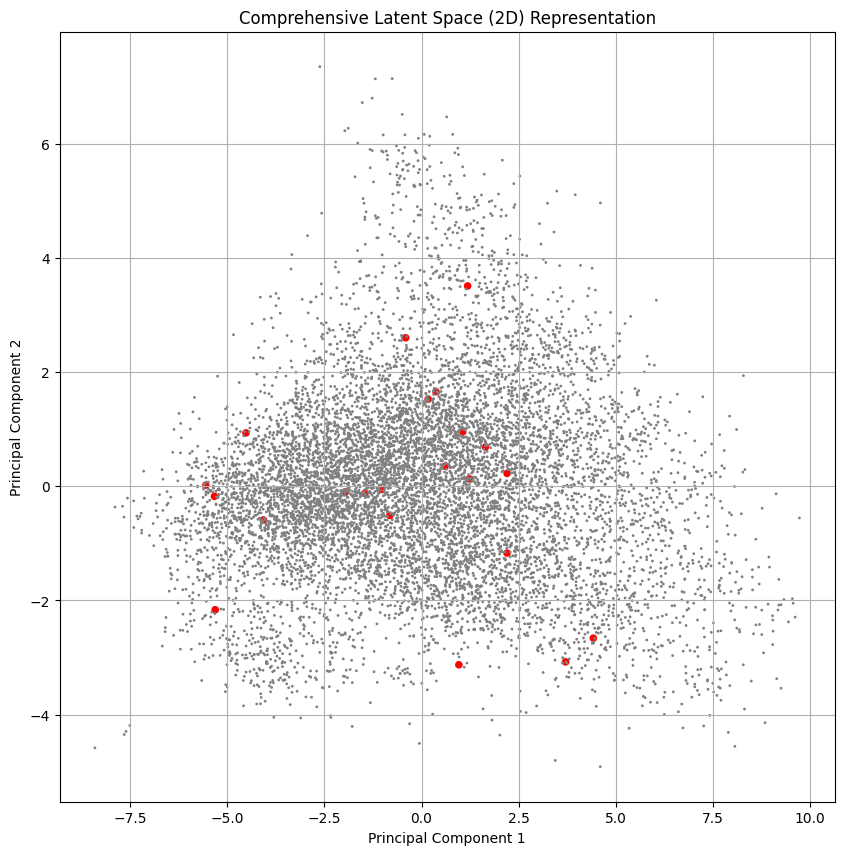

Pair 1: Indices (5053, 117) - Distance: 0.0005303924766060702
Pair 2: Indices (117, 5053) - Distance: 0.0005303924766060702
Pair 3: Indices (1577, 2762) - Distance: 0.0008186354775764048
Pair 4: Indices (2762, 1577) - Distance: 0.0008186354775764048
Pair 5: Indices (2438, 8195) - Distance: 0.0009096985780355721


In [ ]:
plot_latent_space(vae, hf_dataset, num_samples=10000)


I will try to find a way to get a 2D representation that suits my model later.